In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#IMPORT LIBRARY
import os
import pathlib 
import zipfile
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Define dataset directory, train directory and test directory
dataset_dir = '/content/drive/MyDrive/Dataset faceu split'
train_dir = '/content/drive/MyDrive/Dataset faceu split/Train'
test_dir = '/content/drive/MyDrive/Dataset faceu split/Test'

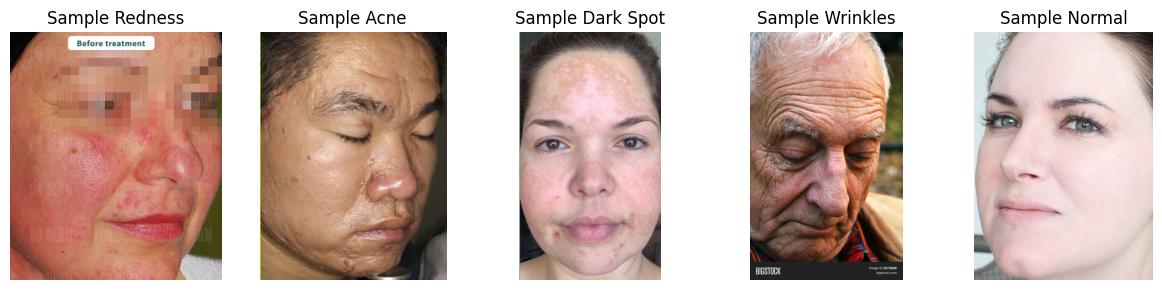

In [ ]:
#Show dataset sample from train dataset
#Initiate all directory in train folder
label_dirs = os.listdir(train_dir)

#initiate the figure and the axis to show the sample data images
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

#Loop through all label directories and show 1 image for each label
for i, label_dir in enumerate(label_dirs):
    label_dir_path = os.path.join(train_dir, label_dir)
    image_files = os.listdir(label_dir_path)
    image_path = os.path.join(label_dir_path, image_files[0])
    image = Image.open(image_path)
    axs[i].imshow(image)
    axs[i].set_title(f'Sample {os.listdir(train_dir)[i]}')
    axs[i].axis('off')

# Show figure
plt.tight_layout()
plt.show()

In [ ]:
def image_generator(train_dir, test_dir):
  #Initiate the ImageDataGenerator class for training dataset
  #Define the augmentation value
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
  
  # Specify the method to load images from a directory and pass in the appropriate arguments:
  # - directory: should be a relative path to the directory containing the data
  # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
  # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
  # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
  #               Pick the one that better suits here given that the labels are going to be 1D binary labels.
  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      target_size=(224, 224),
                                                      batch_size=16,
                                                      class_mode="categorical")
  
  #Initiate the ImageDataGenerator class fro testing dataset
  #Define the augmentation value
  test_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

  return train_generator, test_generator

In [ ]:
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 1448 images belonging to 5 classes.
Found 364 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import MobileNet

pre_trained_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
print(f"The Pre-Trained Model Type was --> {type(pre_trained_model)}")

The Pre-Trained Model Type was --> <class 'keras.engine.functional.Functional'>


In [ ]:
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 3,228,864 total parameters in this model.
There are 3,206,976 trainable parameters in this model.


In [ ]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('conv_pw_13_relu')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 1024)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1024), dtype=tf.float32, name=None), name='conv_pw_13_relu/Relu6:0', description="created by layer 'conv_pw_13_relu'")


In [ ]:
def create_uncompiled_model():
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(128, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)       
    # Add a final sigmoid layer for classification
    x = layers.Dense(5, activation='softmax')(x)         
    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
  
    return model

In [ ]:
uncompiled_model = create_uncompiled_model()

try:
  uncompiled_model.predict(train_generator)
except:
  print("Your current architecture is incompatible with the windowed dataset, try adjusting it!")
else:
  print("Your current architecture is compatible with the windowed dataset!")

91/91 [==============================] - 35s 371ms/step
Your current architecture is compatible with the windowed dataset!


In [ ]:
def lr_scheduler(epoch):
    initial_learning_rate = 0.001
    new_learning_rate = initial_learning_rate * 0.1 ** (epoch // 25)

    return new_learning_rate

In [ ]:
lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
def create_model():
  optimizer = tf.keras.optimizers.Adam()

  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 128 hidden units and ReLU activation
  x = layers.Dense(128, activation='relu')(x)
  # Add a dropout rate
  x = layers.Dropout(0.2)(x)       
  # Add a final sigmoid layer for classification
  x = x = layers.Dense(5, activation='softmax')(x)         
  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)
  # Compile the model
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [ ]:
myModel = create_model()

In [ ]:
# Inspect parameters
total_params = myModel.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in myModel.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 9,652,165 total parameters in this model.
There are 9,630,277 trainable parameters in this model.


In [ ]:
history = myModel.fit(train_generator,
                    validation_data = test_generator,
                    epochs = 100,
                    callbacks=lr_callback,
                    verbose = 2)

Epoch 1/100
91/91 - 63s - loss: 4.3453 - accuracy: 0.4316 - val_loss: 2.2693 - val_accuracy: 0.3269 - lr: 0.0010 - 63s/epoch - 693ms/step
Epoch 2/100
91/91 - 40s - loss: 0.9243 - accuracy: 0.6153 - val_loss: 1.8632 - val_accuracy: 0.5934 - lr: 0.0010 - 40s/epoch - 438ms/step
Epoch 3/100
91/91 - 40s - loss: 0.8865 - accuracy: 0.6740 - val_loss: 0.7811 - val_accuracy: 0.7170 - lr: 0.0010 - 40s/epoch - 439ms/step
Epoch 4/100
91/91 - 41s - loss: 0.7507 - accuracy: 0.7244 - val_loss: 0.5783 - val_accuracy: 0.7665 - lr: 0.0010 - 41s/epoch - 446ms/step
Epoch 5/100
91/91 - 40s - loss: 0.7469 - accuracy: 0.7265 - val_loss: 0.9934 - val_accuracy: 0.6181 - lr: 0.0010 - 40s/epoch - 437ms/step
Epoch 6/100
91/91 - 40s - loss: 0.8597 - accuracy: 0.6623 - val_loss: 1.9416 - val_accuracy: 0.6236 - lr: 0.0010 - 40s/epoch - 441ms/step
Epoch 7/100
91/91 - 40s - loss: 0.7301 - accuracy: 0.7258 - val_loss: 1.7660 - val_accuracy: 0.3929 - lr: 0.0010 - 40s/epoch - 437ms/step
Epoch 8/100
91/91 - 45s - loss: 0.

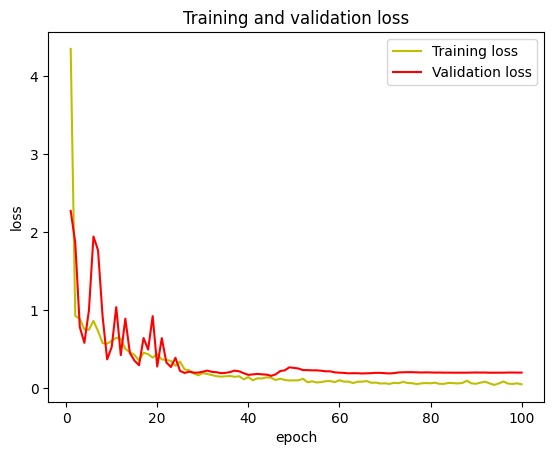

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'y',label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

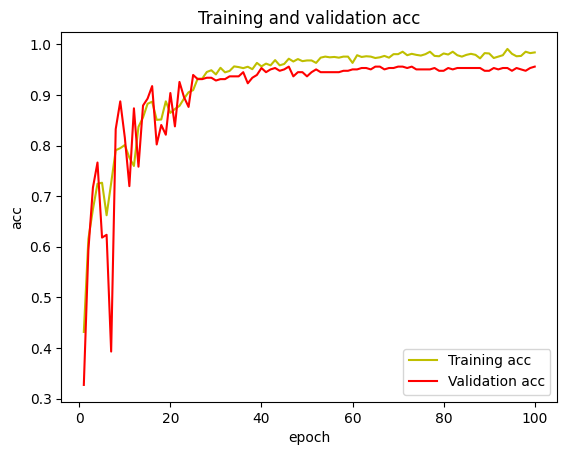

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,len(loss)+1)

plt.plot(epochs,acc,'y',label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
myModel.save("/content/drive/MyDrive/Model h5/Model_dataset baru.h5")
myModel.save("/content/drive/MyDrive/Model h5/Model_dataset baru.pb")

In [ ]:
image_path = '/content/drive/MyDrive/GettyImages-546459592-5b215d8996c74956bc733aa9f6dd21a8.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)
image_array = image_array / 255.0  # Normalisasi

In [ ]:
predictions = myModel.predict(image_array)
predicted_class = tf.argmax(predictions[0])

1/1 [==============================] - 0s 23ms/step


In [ ]:
description = ""
if predicted_class == 0:
    description = "Ini adalah Acne."
elif predicted_class == 1:
    description = "Ini adalah Dark Spot."
elif predicted_class == 2:
    description = "Ini adalah Kemerahan."
elif predicted_class == 3:
    description = "Ini adalah Kerutan."
  
print(description)

Ini adalah Kemerahan.


Deteksi

In [ ]:
class_name = train_generator.class_indices
class_name = list(dict.keys(class_name))
print(class_name)

['Acne', 'Dark Spot', 'Normal', 'Redness', 'Wrinkles']


In [ ]:
image_path = '/content/drive/MyDrive/WhatsApp Image 2023-06-06 at 23.14.03.jpeg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)
image_array = image_array / 255.0  # Normalisasi

In [ ]:
def decode_predictions(predictions, labels, threshold=0.001):
    decoded_labels = []
    scores = []
    for i, pred in enumerate(predictions[0]):
        if pred >= threshold:
            decoded_labels.append(labels[i])
            scores.append(pred)
    return decoded_labels, scores

# Misalnya, jika Anda memiliki empat label yang sesuai dengan hasil prediksi model Anda
labels = ['Acne', 'Dark Spot', 'Normal', 'Redness', 'Wrinkles']

# Lakukan prediksi pada data
predictions = myModel.predict(image_array)

# Dapatkan label-label yang terdekode dan skor (probabilitas) berdasarkan probabilitas di atas ambang batas 0.5
decoded_labels, scores = decode_predictions(predictions, labels)

print(decoded_labels)
print(scores)

1/1 [==============================] - 0s 25ms/step
['Normal']
[0.9991648]
